


1/1 [==============================] - 0s 18ms/step


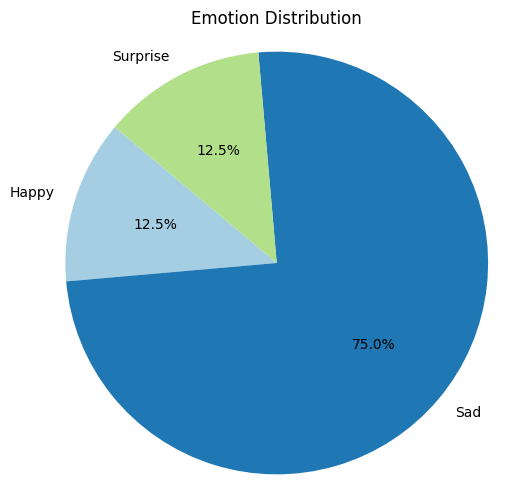

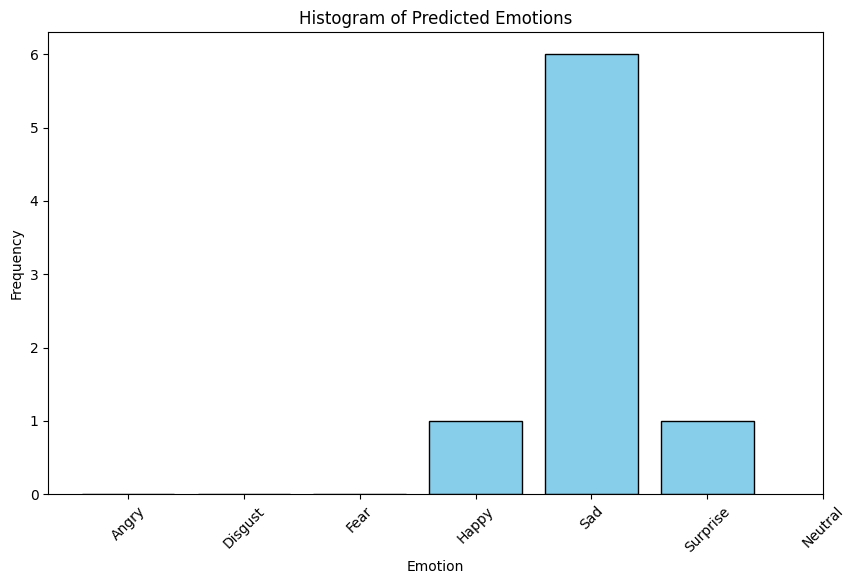

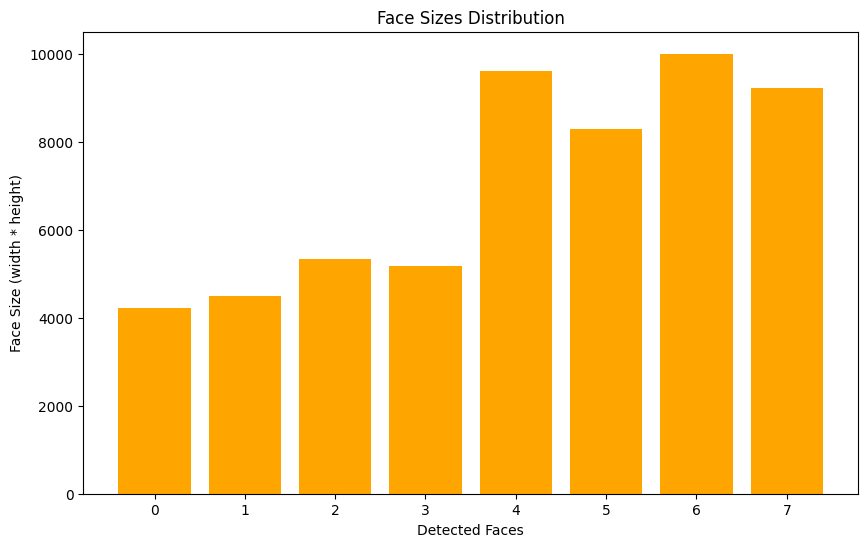

1/1 [==============================] - 0s 18ms/step


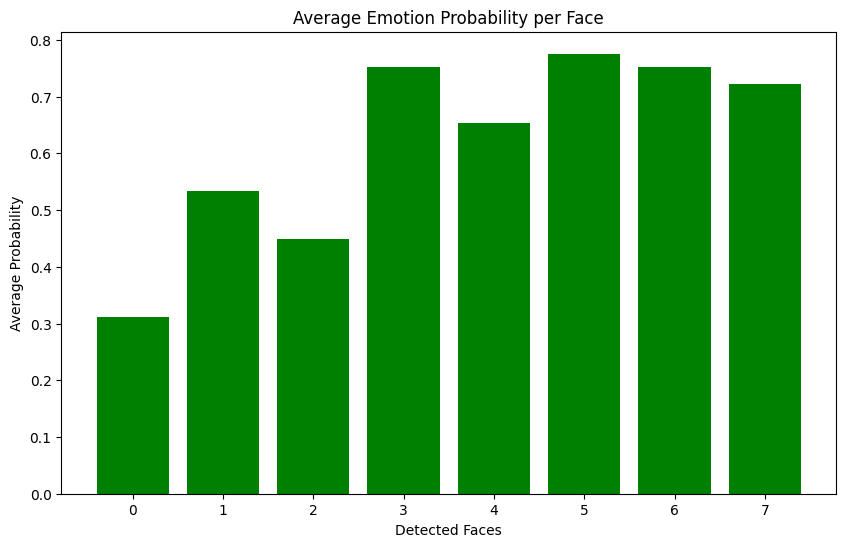

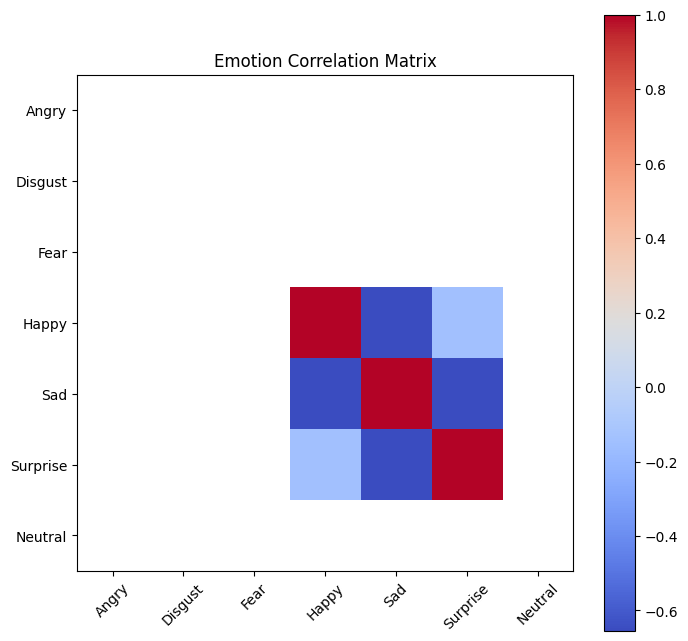

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

from keras.models import load_model

# Load the saved model
model = load_model('model_optimal.h5')

image_size = 48

emotion_mapping_inv = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

#loading and preprocessing image
def load_and_preprocess(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (image_size, image_size))
    image = image / 255.0  #normalizing pixel values
    return image

def preprocess_face(face):
    #resize the face to match the input size of the model
    resized_face = cv2.resize(face, (image_size, image_size))

    #convert to grayscale
    gray_face = cv2.cvtColor(resized_face, cv2.COLOR_BGR2GRAY)

    #normalize pixel values
    normalized_face = gray_face / 255.0

    return normalized_face

def most_common_element(lst):
    return max(set(lst), key=lst.count)

#load the input image
image_path = "Zoom_Hand_Raise_82521.jpg"
input_image = cv2.imread(image_path)

#check if the image is successfully loaded
if input_image is None:
    print("Error: Unable to load the input image.")
else:
    #face detection method
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
    detected_faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    #processed image for visualization
    processed_image = input_image.copy()

    #pre-process and predict emotions for each detected face
    emotions = []
    for (x, y, w, h) in detected_faces:
        #extract the face region
        face = input_image[y:y+h, x:x+w]

        #preprocess the face
        preprocessed_face = preprocess_face(face)

        #predict emotion using the trained model
        emotion_prediction = model.predict(preprocessed_face.reshape(1, image_size, image_size, 1))

        #append the predicted emotion to the list
        emotions.append(np.argmax(emotion_prediction))

        #draw bounding box and emotion label on the processed image
        cv2.rectangle(processed_image, (x, y), (x+w, y+h), (0, 255, 0), 2)
        emotion_label = emotion_mapping_inv[np.argmax(emotion_prediction)]
        cv2.putText(processed_image, emotion_label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    #display the processed image
    cv2.imshow("Processed Image", processed_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()




#Pie chart - emotion distribution
plt.figure(figsize=(6, 6))
plt.title('Emotion Distribution')
labels = [emotion_mapping_inv[i] for i in set(emotions)]
sizes = [emotions.count(i) for i in set(emotions)]
colors = plt.cm.Paired(range(len(labels)))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.axis('equal')  #equal aspect ratio so that the pie is drawn as a circle
plt.show()

#Histogram - emotion frequency
plt.figure(figsize=(10, 6))
plt.title('Histogram of Predicted Emotions')
plt.hist(emotions, bins=range(7), align='left', rwidth=0.8, color='skyblue', edgecolor='black')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.xticks(range(7), [emotion_mapping_inv[i] for i in range(7)], rotation=45)
plt.show()

#bar chart - face sizes
face_sizes = [w * h for (_, _, w, h) in detected_faces]
plt.figure(figsize=(10, 6))
plt.bar(range(len(face_sizes)), face_sizes, color='orange')
plt.title('Face Sizes Distribution')
plt.xlabel('Detected Faces')
plt.ylabel('Face Size (width * height)')
plt.show()

#bar chart - average emotion probability
average_probs = [np.max(model.predict(preprocess_face(input_image[y:y+h, x:x+w]).reshape(1, image_size, image_size, 1))) 
                 for (x, y, w, h) in detected_faces]
plt.figure(figsize=(10, 6))
plt.bar(range(len(average_probs)), average_probs, color='green')
plt.title('Average Emotion Probability per Face')
plt.xlabel('Detected Faces')
plt.ylabel('Average Probability')
plt.show()

#suppress warnings
np.seterr(divide='ignore', invalid='ignore')

#correlation matrix - emotions
emotions_one_hot = np.eye(len(emotion_mapping_inv))[emotions]
correlation_matrix = np.corrcoef(emotions_one_hot.T)
np.seterr(divide='warn', invalid='warn')

plt.figure(figsize=(8, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(emotion_mapping_inv)), list(emotion_mapping_inv.values()), rotation=45)
plt.yticks(range(len(emotion_mapping_inv)), list(emotion_mapping_inv.values()))
plt.title('Emotion Correlation Matrix')
plt.show()


